<a href="https://colab.research.google.com/github/ankit-kothari/Data-Science-Journey/blob/master/textual_entailment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers 
!pip install dask
!pip install 'fsspec>=0.3.3'
!pip3 install evaluate


In [158]:
!pip install datasets
!pip install torchinfo

In [159]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun 19 05:26:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    32W / 250W |  11569MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [160]:
from transformers import pipeline
import torch
import spacy
import tqdm as notebook_tqdm
from torchinfo import summary
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
from datasets import load_dataset
from spacy.lang.en import English
import warnings
from tqdm import tqdm
import re
import string
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import concurrent.futures
import dask.bag as db
import dask 
import graphviz
from dask import visualize

## Loading Data Set

In [ ]:
raw_datasets = load_dataset('glue','rte')

In [162]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3000
    })
})

In [163]:
raw_datasets['train'].features

{'idx': Value(dtype='int32', id=None),
 'label': ClassLabel(num_classes=2, names=['entailment', 'not_entailment'], id=None),
 'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None)}

## Exploring Data 

In [164]:
raw_datasets.set_format(type='pandas')
rte_data = raw_datasets['train'][:]

In [165]:
rte_data.head()

,sentence1,sentence2,label,idx
0,No Weapons of Mass Destruction Found in Iraq Yet.,Weapons of Mass Destruction Found in Iraq.,1,0
1,"A place of sorrow, after Pope John Paul II died, became a place of celebration, as Roman Catholic faithful gathered in downtown Chicago to mark the installation of new Pope Benedict XVI.",Pope Benedict XVI is the new leader of the Roman Catholic Church.,0,1
2,"Herceptin was already approved to treat the sickest breast cancer patients, and the company said, Monday, it will discuss with federal regulators the possibility of prescribing the drug for more breast cancer patients.",Herceptin can be used to treat breast cancer.,0,2
3,"Judie Vivian, chief executive at ProMedica, a medical service company that helps sustain the 2-year-old Vietnam Heart Institute in Ho Chi Minh City (formerly Saigon), said that so far about 1,500 children have received treatment.",The previous name of Ho Chi Minh City was Saigon.,0,3
4,"A man is due in court later charged with the murder 26 years ago of a teenager whose case was the first to be featured on BBC One's Crimewatch. Colette Aram, 16, was walking to her boyfriend's house in Keyworth, Nottinghamshire, on 30 October 1983 when she disappeared. Her body was later found in a field close to her home. Paul Stewart Hutchinson, 50, has been charged with murder and is due before Nottingham magistrates later.",Paul Stewart Hutchinson is accused of having stabbed a girl.,1,4


#### Distribution of Labels

[]

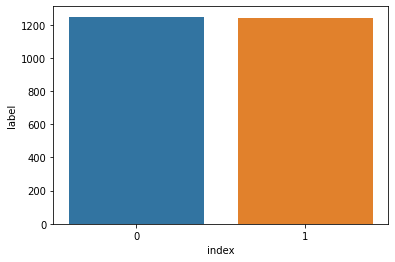

In [166]:
import seaborn as sns
label_hist = rte_data['label'].value_counts().reset_index()
ax = sns.barplot(x='index',y='label',data=label_hist)
plt.plot()


In [167]:
rte_data['sentence1_length']= rte_data['sentence1'].apply(lambda x: len(x.split(' ')))
rte_data['sentence2_length']= rte_data['sentence2'].apply(lambda x: len(x.split(' ')))

#### Distribution of Lenght of Sentence 1 and Sentence 2

In [168]:
rte_data.groupby(['label'])['sentence1_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,1249.0,44.257806,32.763613,6.0,22.0,31.0,56.0,158.0
1,1241.0,43.006446,32.245079,4.0,22.0,31.0,53.0,239.0


In [169]:
rte_data.groupby(['label'])['sentence2_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,1249.0,8.438751,3.674841,3.0,6.0,8.0,10.0,28.0
1,1241.0,9.152297,4.995176,3.0,6.0,8.0,10.0,41.0


In [170]:
raw_datasets.reset_format()

## Tokenization

In [171]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments,Trainer 

In [172]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [173]:
result= tokenizer(raw_datasets['train']['sentence1'],
          raw_datasets['train']['sentence1'])
result['input_ids'][0]

[101,
 2053,
 4255,
 1997,
 3742,
 6215,
 2179,
 1999,
 5712,
 2664,
 1012,
 102,
 2053,
 4255,
 1997,
 3742,
 6215,
 2179,
 1999,
 5712,
 2664,
 1012,
 102]

In [174]:
tokenizer.decode(result['input_ids'][0])

'[CLS] no weapons of mass destruction found in iraq yet. [SEP] no weapons of mass destruction found in iraq yet. [SEP]'

In [ ]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence1'], batch['sentence2'],truncation=True,padding=True)

tokenized_dataset = raw_datasets.map(tokenize_fn, batched=True)

In [176]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 3000
    })
})

## Auto Config

In [177]:
from transformers import AutoConfig
#Autoconfig can also be replaced by checkpoint specific configs
config = AutoConfig.from_pretrained(checkpoint)
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.20.0",
  "vocab_size": 30522
}

In [178]:
print(config.id2label)
print(config.label2id)

{0: 'LABEL_0', 1: 'LABEL_1'}
{'LABEL_0': 0, 'LABEL_1': 1}


In [179]:
target_map = {'entailment': 0,  'not_entailment': 1}
config.id2label = {v:k for k,v in target_map.items()}
print(config.id2label)
config.label2id = target_map
print(config.label2id)

{0: 'entailment', 1: 'not_entailment'}
{'entailment': 0, 'not_entailment': 1}


## Modeling

In [180]:
num_labels=2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config).to(device)) #num_labels=num_labels

## Training Arguments

In [181]:
batch_size= 32
logging_steps = len(tokenized_dataset["train"]) // batch_size
model_name = "textual_entailment_model"
training_args = TrainingArguments(
    'textual_entailment_lp',
    evaluation_strategy='epoch',
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy='epoch',
    logging_steps=logging_steps,
    log_level="error",
    push_to_hub=False,
    disable_tqdm=False
    )

## Evaluation Metric

In [182]:
import evaluate

def compute_metrics(pred):
  labels=pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels,preds, average="weighted"),
  acc = accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1}

## Training

In [183]:
from transformers import Trainer 
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset = tokenized_dataset['validation'],
                  tokenizer=tokenizer)

In [184]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.695200,0.686724,0.559567,"(0.534967740921177,)"
2,0.673700,0.677415,0.555957,"(0.5073881119265976,)"
3,0.612300,0.666405,0.613718,"(0.6139399696962295,)"
4,0.521900,0.694774,0.599278,"(0.5995706860053385,)"
5,0.448500,0.700915,0.606498,"(0.6046121635146848,)"


TrainOutput(global_step=390, training_loss=0.5888840724260379, metrics={'train_runtime': 194.4856, 'train_samples_per_second': 64.015, 'train_steps_per_second': 2.005, 'total_flos': 930906882293400.0, 'train_loss': 0.5888840724260379, 'epoch': 5.0})

## Testing

In [185]:
trainer.save_model('my_saved_model_textual_entailment')

In [186]:
from transformers import pipeline

In [187]:
savedmodel = pipeline('text-classification',model='my_saved_model_textual_entailment',device=0)

In [188]:
test_pred = savedmodel(raw_datasets['validation']['sentence1'],raw_datasets['validation']['sentence2'])

In [189]:
test_pred[0:10]

[{'label': 'entailment', 'score': 0.7552555799484253},
 {'label': 'not_entailment', 'score': 0.868709146976471},
 {'label': 'entailment', 'score': 0.5223768949508667},
 {'label': 'not_entailment', 'score': 0.6073724627494812},
 {'label': 'not_entailment', 'score': 0.6777898073196411},
 {'label': 'not_entailment', 'score': 0.5208828449249268},
 {'label': 'not_entailment', 'score': 0.686109185218811},
 {'label': 'entailment', 'score': 0.5045697093009949},
 {'label': 'not_entailment', 'score': 0.901530921459198},
 {'label': 'entailment', 'score': 0.6365092992782593}]

In [190]:
test_inx = [target_map[k['label']] for k in test_pred]
test_inx[0:2]

[0, 1]

In [191]:
tokenized_dataset['validation']['label'][0:2]

[1, 0]

In [192]:
cm = confusion_matrix(raw_datasets['validation']['label'], test_inx, labels=[0, 1])

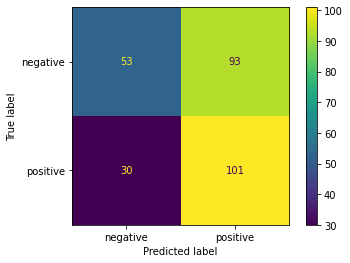

In [193]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative', 'positive','neutral'])
disp.plot()
plt.grid(False)
plt.show()